*This collab notebook generates downloadable CSV files. In order to reproduce all analyses you'll need to create a folder to house this .ipynb in your Google Drive, then store any downloadable files generated by this notebook in that same folder. When importing said files, for downstream analysis, you'll need to update the file paths accordingly as well (the default path is '/content/drive/MyDrive/Mouse_AD/').*

## **Dependencies**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip installations
!pip install mygene
!pip install gseapy
!pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.5/548.5 kB 9.0 MB/s eta 0:00:00


In [ ]:
 # import libraries (versions)
import os
import subprocess
import gzip
import pandas as pd #v2.2.2
import mygene #v3.2.2
import numpy as np #v1.26.4
import matplotlib.pyplot as plt
import seaborn as sns #v0.13.2
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import gseapy as gp #v1.1.4
from matplotlib_venn import venn3
import requests #v2.32.3
import networkx as nx #v3.4.2
from io import StringIO

## **Load, Inspect, and Prepare Data**


### **Load, Inspect, and Prepare Data for 5xFAD Model**

In [ ]:
# Define function to download gzipped file from url, unzip it, and load it into pandas DF
def download_and_load_data(url, output_filename, sep="\t", column_filter=None):
    # Step 1: Download the file using wget
    print(f"Downloading {output_filename} from {url}...")
    subprocess.run(["wget", "-O", output_filename + ".gz", url], check=True)

    # Step 2: Gunzip the file
    print(f"Unzipping {output_filename}.gz...")
    with gzip.open(output_filename + ".gz", "rb") as gz_file:
        with open(output_filename, "wb") as out_file:
            out_file.write(gz_file.read())

    # Step 3: Load the data into a pandas DataFrame
    print(f"Loading {output_filename} into a pandas DataFrame...")
    df = pd.read_csv(output_filename, sep=sep, index_col=0)

    # Optional: Filter columns based on the keyword
    if column_filter:
        print(f"Filtering columns with keyword '{column_filter}'...")
        filtered_columns = [col for col in df.columns if column_filter in col]
        df = df[filtered_columns]

    return df

In [ ]:
# Load data for 5xFAD mouse model (8mo only)
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE168137&format=file&file=GSE168137%5FcountList%2Etxt%2Egz"
output_filename = "GSE168137_countList.txt"
column_keyword = "cortex_8mon"
countlist_5xFAD = download_and_load_data(url, output_filename, column_filter=column_keyword)

# Rename columns
new_column_names = ["5xFAD_cortex_8mon_Female_295", "5xFAD_cortex_8mon_Female_312","5xFAD_cortex_8mon_Female_339", "5xFAD_cortex_8mon_Female_341", "5xFAD_cortex_8mon_Female_342", "5xFAD_cortex_8mon_Male_299", "5xFAD_cortex_8mon_Male_300", "5xFAD_cortex_8mon_Male_307", "5xFAD_cortex_8mon_Male_387", "5xFAD_cortex_8mon_Male_390",  "BL6_cortex_8mon_Female_322", "BL6_cortex_8mon_Female_338", "BL6_cortex_8mon_Female_340",  "BL6_cortex_8mon_Female_348", "BL6_cortex_8mon_Female_351", "BL6_cortex_8mon_Male_389", "BL6_cortex_8mon_Male_396", "BL6_cortex_8mon_Male_399", "BL6_cortex_8mon_Male_410", "BL6_cortex_8mon_Male_412"]
countlist_5xFAD.columns = new_column_names

# Drop ensemble version ID from gene_id's
countlist_5xFAD.index = countlist_5xFAD.index.str.split('.').str[0]

# View first 5 rows of data
countlist_5xFAD.head()

Unzipping GSE168137_countList.txt.gz...
Loading GSE168137_countList.txt into a pandas DataFrame...
Filtering columns with keyword 'cortex_8mon'...


,5xFAD_cortex_8mon_Female_295,5xFAD_cortex_8mon_Female_312,5xFAD_cortex_8mon_Female_339,5xFAD_cortex_8mon_Female_341,5xFAD_cortex_8mon_Female_342,5xFAD_cortex_8mon_Male_299,5xFAD_cortex_8mon_Male_300,5xFAD_cortex_8mon_Male_307,5xFAD_cortex_8mon_Male_387,5xFAD_cortex_8mon_Male_390,BL6_cortex_8mon_Female_322,BL6_cortex_8mon_Female_338,BL6_cortex_8mon_Female_340,BL6_cortex_8mon_Female_348,BL6_cortex_8mon_Female_351,BL6_cortex_8mon_Male_389,BL6_cortex_8mon_Male_396,BL6_cortex_8mon_Male_399,BL6_cortex_8mon_Male_410,BL6_cortex_8mon_Male_412
gene_id,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001,729.0,614.0,610.0,614.0,484.0,613.0,607.0,393.0,645.0,339.0,465.0,497.0,673.0,396.0,500.0,711.0,325.0,777.0,837.0,670.0
ENSMUSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000028,21.0,38.0,31.0,35.0,19.0,40.0,34.0,23.0,34.0,19.0,28.0,25.0,34.0,23.0,32.0,29.0,15.0,44.0,36.0,24.0
ENSMUSG00000000031,4.0,4.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,5.0,1.0,1.0,0.0,2.0
ENSMUSG00000000037,5.0,11.0,7.0,3.0,2.0,5.0,2.0,3.0,5.0,2.0,5.0,3.0,2.0,3.0,2.0,4.0,4.0,8.0,7.0,2.0


In [ ]:
# create MyGeneInfo object
mg = mygene.MyGeneInfo()

# get the ensembl id from index
ensembl_ids = countlist_5xFAD.index.tolist()

# query the gene symbols for the ensemble ids and onvert result to dataframe
gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='mouse')
gene_df = pd.DataFrame(gene_info)

# remove duplicate ensemble ids and rows where symbol is missing or duplicated
gene_df = gene_df.dropna(subset=['symbol']).drop_duplicates(subset='query')

# map gene symbols back to original dataframe and move gene_name column to front column
countlist_5xFAD['Gene_Name'] = countlist_5xFAD.index.map(gene_df.set_index('query')['symbol'])
cols = ['Gene_Name'] + [col for col in countlist_5xFAD.columns if col != 'Gene_Name']
countlist_5xFAD = countlist_5xFAD[cols]


INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

In [ ]:
countlist_5xFAD.head()

,Gene_Name,5xFAD_cortex_8mon_Female_295,5xFAD_cortex_8mon_Female_312,5xFAD_cortex_8mon_Female_339,5xFAD_cortex_8mon_Female_341,5xFAD_cortex_8mon_Female_342,5xFAD_cortex_8mon_Male_299,5xFAD_cortex_8mon_Male_300,5xFAD_cortex_8mon_Male_307,5xFAD_cortex_8mon_Male_387,...,BL6_cortex_8mon_Female_322,BL6_cortex_8mon_Female_338,BL6_cortex_8mon_Female_340,BL6_cortex_8mon_Female_348,BL6_cortex_8mon_Female_351,BL6_cortex_8mon_Male_389,BL6_cortex_8mon_Male_396,BL6_cortex_8mon_Male_399,BL6_cortex_8mon_Male_410,BL6_cortex_8mon_Male_412
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001,Gnai3,729.0,614.0,610.0,614.0,484.0,613.0,607.0,393.0,645.0,...,465.0,497.0,673.0,396.0,500.0,711.0,325.0,777.0,837.0,670.0
ENSMUSG00000000003,Pbsn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000028,Cdc45,21.0,38.0,31.0,35.0,19.0,40.0,34.0,23.0,34.0,...,28.0,25.0,34.0,23.0,32.0,29.0,15.0,44.0,36.0,24.0
ENSMUSG00000000031,H19,4.0,4.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,1.0,5.0,1.0,1.0,0.0,2.0
ENSMUSG00000000037,Scml2,5.0,11.0,7.0,3.0,2.0,5.0,2.0,3.0,5.0,...,5.0,3.0,2.0,3.0,2.0,4.0,4.0,8.0,7.0,2.0


In [ ]:
# check for missing values
print(countlist_5xFAD.isnull().sum())

Gene_Name                       3960
5xFAD_cortex_8mon_Female_295       0
5xFAD_cortex_8mon_Female_312       0
5xFAD_cortex_8mon_Female_339       0
5xFAD_cortex_8mon_Female_341       0
5xFAD_cortex_8mon_Female_342       0
5xFAD_cortex_8mon_Male_299         0
5xFAD_cortex_8mon_Male_300         0
5xFAD_cortex_8mon_Male_307         0
5xFAD_cortex_8mon_Male_387         0
5xFAD_cortex_8mon_Male_390         0
BL6_cortex_8mon_Female_322         0
BL6_cortex_8mon_Female_338         0
BL6_cortex_8mon_Female_340         0
BL6_cortex_8mon_Female_348         0
BL6_cortex_8mon_Female_351         0
BL6_cortex_8mon_Male_389           0
BL6_cortex_8mon_Male_396           0
BL6_cortex_8mon_Male_399           0
BL6_cortex_8mon_Male_410           0
BL6_cortex_8mon_Male_412           0
dtype: int64


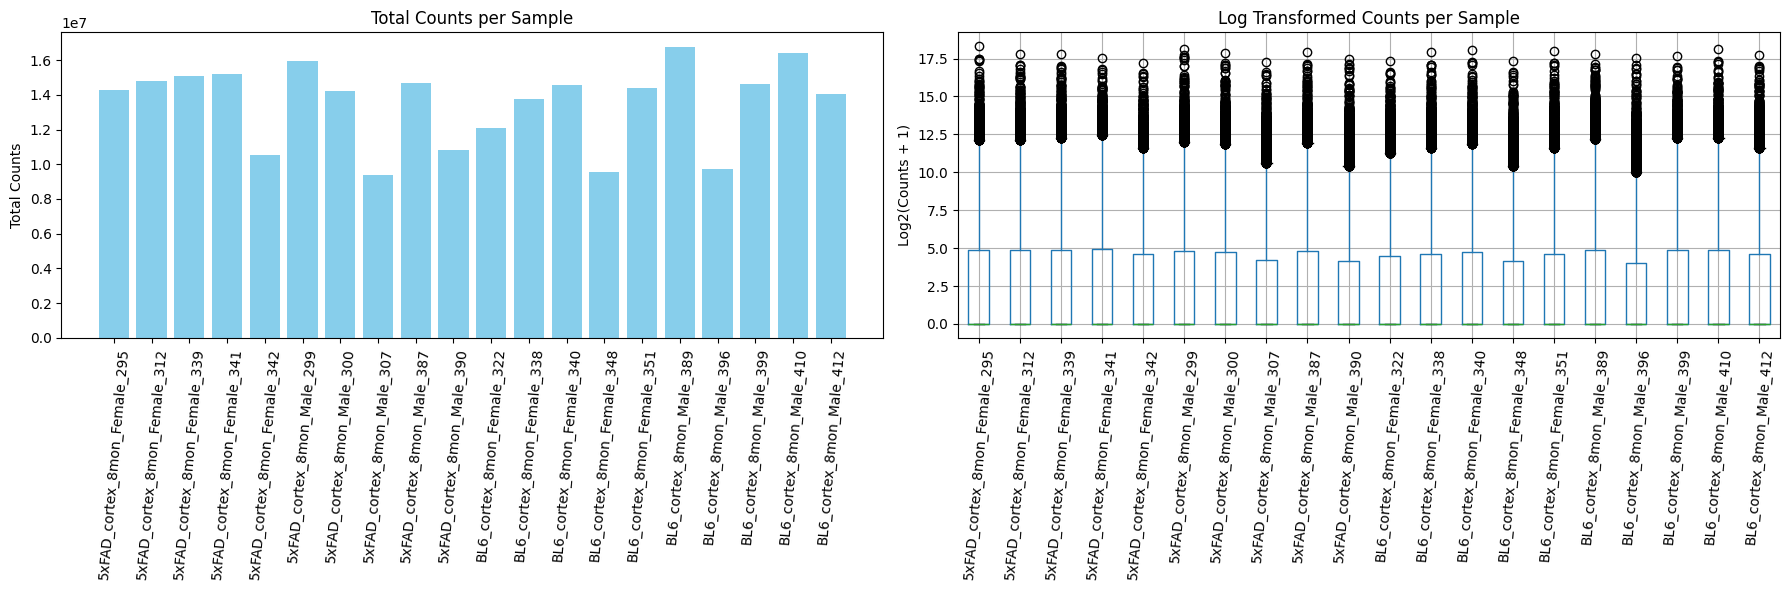

In [ ]:
# Drop the Gene Name column from countlist_5xFAD for counting
countlist_no_name = countlist_5xFAD.iloc[:, 1:]

# Calculate total counts per sample and log transform counts
total_counts = countlist_no_name.sum(axis=0)
log_counts = countlist_no_name.apply(lambda x: np.log2(x + 1))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot total counts per sample
axes[0].bar(countlist_no_name.columns, total_counts, color='skyblue')  # Use countlist_no_name columns here
axes[0].set_ylabel('Total Counts')
axes[0].set_title('Total Counts per Sample')
axes[0].tick_params(axis='x', rotation=85)

# Plot log transformed counts per sample
log_counts.boxplot(ax=axes[1])
axes[1].set_ylabel('Log2(Counts + 1)')
axes[1].set_title('Log Transformed Counts per Sample')
axes[1].tick_params(axis='x', rotation=85)

plt.tight_layout()
plt.show()

In [ ]:
# download dataframe with cleaned 5xFAD countlist
countlist_5xFAD.to_csv('countlist_5xFAD.csv')
from google.colab import files
files.download('countlist_5xFAD.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Load, Inspect, and Prepare Data for 3xTG-AD Model**

In [ ]:
# Load data for 3xTG-AS mouse model (8mo only)
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE161904&format=file&file=GSE161904%5FRaw%5Fgene%5Fcounts%5Fcortex%2Etxt%2Egz"
output_filename = "GSE161904_Raw_gene_counts_cortex.txt"
column_keyword = "G3" #keyword for 8mo old data
countlist_3xTG_AD = download_and_load_data(url, output_filename, column_filter=column_keyword)

# Rename columns
new_column_names = ['3xTG_AD_Cortex_R1', '3xTG_AD_Cortex_R3', '3xTG_AD_Cortex_R4', 'WT_Cortex_R10', 'WT_Cortex_R17', 'WT_Cortex_R9']
countlist_3xTG_AD.columns = new_column_names

# Add column name to index
countlist_3xTG_AD.index.set_names('gene_id', inplace=True)

# View first 5 rows of data
countlist_3xTG_AD.head()

Unzipping GSE161904_Raw_gene_counts_cortex.txt.gz...
Loading GSE161904_Raw_gene_counts_cortex.txt into a pandas DataFrame...
Filtering columns with keyword 'G3'...


,3xTG_AD_Cortex_R1,3xTG_AD_Cortex_R3,3xTG_AD_Cortex_R4,WT_Cortex_R10,WT_Cortex_R17,WT_Cortex_R9
gene_id,,,,,,
ENSMUSG00000000001,1020,1095,1203,1225,1116,1106
ENSMUSG00000000003,0,0,0,0,0,0
ENSMUSG00000000028,63,77,59,90,69,97
ENSMUSG00000000031,3,0,3,0,2,1
ENSMUSG00000000037,91,78,73,111,72,125


In [ ]:
# create MyGeneInfo object
mg = mygene.MyGeneInfo()

# get the ensembl id from index
ensembl_ids = countlist_3xTG_AD.index.tolist()

# query the gene symbols for the ensemble ids and onvert result to dataframe
gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='mouse')
gene_df = pd.DataFrame(gene_info)

# remove duplicate ensemble ids and rows where symbol is missing or duplicated
gene_df = gene_df.dropna(subset=['symbol']).drop_duplicates(subset='query')

# map gene symbols back to original dataframe and move gene_name column to front column
countlist_3xTG_AD['Gene_Name'] = countlist_3xTG_AD.index.map(gene_df.set_index('query')['symbol'])
cols = ['Gene_Name'] + [col for col in countlist_3xTG_AD.columns if col != 'Gene_Name']
countlist_3xTG_AD = countlist_3xTG_AD[cols]

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

In [ ]:
# view first 5 rows of data to make sure gene_names are added
countlist_3xTG_AD.head()

,Gene_Name,3xTG_AD_Cortex_R1,3xTG_AD_Cortex_R3,3xTG_AD_Cortex_R4,WT_Cortex_R10,WT_Cortex_R17,WT_Cortex_R9
gene_id,,,,,,,
ENSMUSG00000000001,Gnai3,1020,1095,1203,1225,1116,1106
ENSMUSG00000000003,Pbsn,0,0,0,0,0,0
ENSMUSG00000000028,Cdc45,63,77,59,90,69,97
ENSMUSG00000000031,H19,3,0,3,0,2,1
ENSMUSG00000000037,Scml2,91,78,73,111,72,125


In [ ]:
# check for missing values
print(countlist_3xTG_AD.isnull().sum())

Gene_Name            4604
3xTG_AD_Cortex_R1       0
3xTG_AD_Cortex_R3       0
3xTG_AD_Cortex_R4       0
WT_Cortex_R10           0
WT_Cortex_R17           0
WT_Cortex_R9            0
dtype: int64


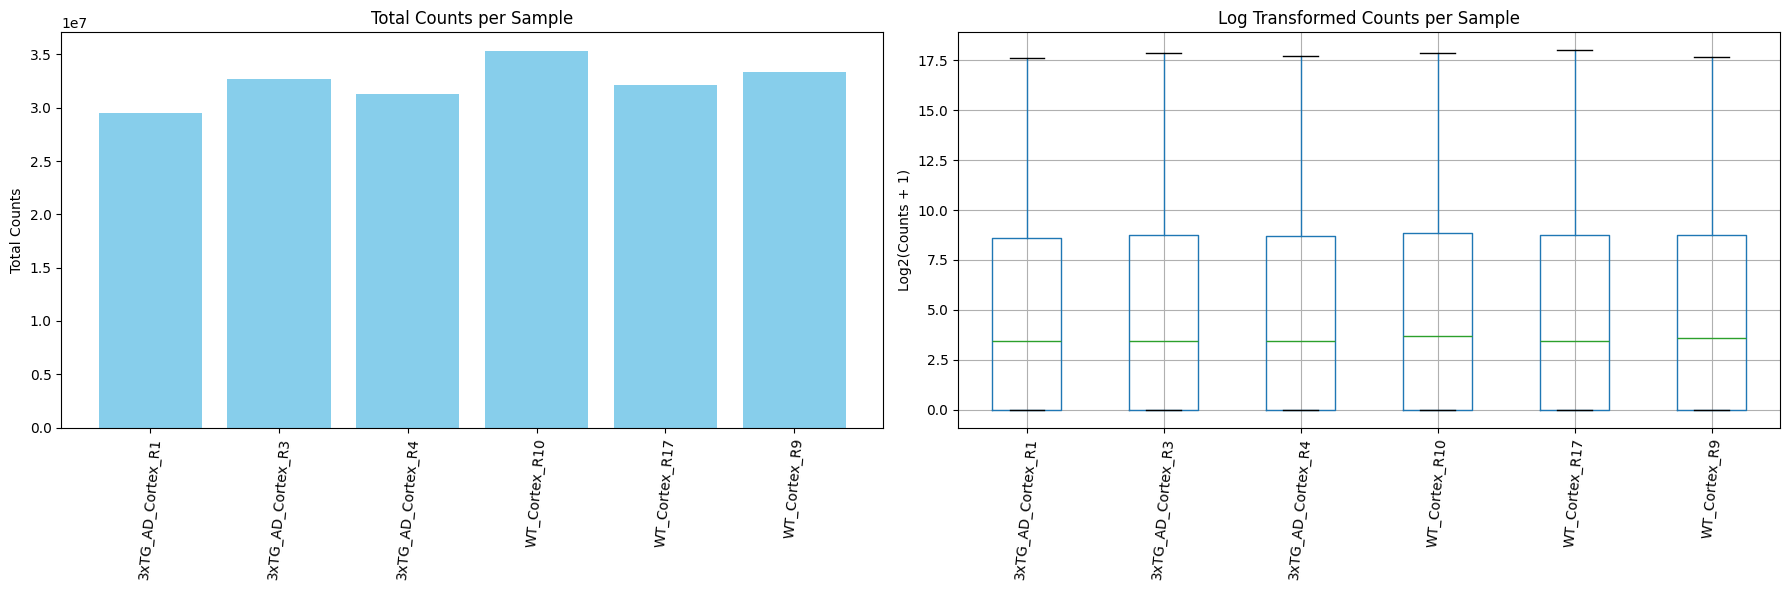

In [ ]:
# Drop the Gene Name column from countlist_3xTG_AD for counting
countlist_no_name = countlist_3xTG_AD.iloc[:, 1:]

# Calculate total counts per sample and log transform counts
total_counts = countlist_no_name.sum(axis=0)
log_counts = countlist_no_name.apply(lambda x: np.log2(x + 1))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot total counts per sample
axes[0].bar(countlist_no_name.columns, total_counts, color='skyblue')  # Use countlist_no_name columns here
axes[0].set_ylabel('Total Counts')
axes[0].set_title('Total Counts per Sample')
axes[0].tick_params(axis='x', rotation=85)

# Plot log transformed counts per sample
log_counts.boxplot(ax=axes[1])
axes[1].set_ylabel('Log2(Counts + 1)')
axes[1].set_title('Log Transformed Counts per Sample')
axes[1].tick_params(axis='x', rotation=85)

plt.tight_layout()
plt.show()

In [ ]:
# download dataframe with cleaned 3xTG-AD countlist
countlist_3xTG_AD.to_csv('countlist_3xTG_AD.csv')
from google.colab import files
files.download('countlist_3xTG_AD.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Load, Inspect, and Prepare Data for PS301S**


In [ ]:
# Load data for 3xTG-AS mouse model (8mo only)
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE118523&format=file&file=GSE118523%5F20161109%5Fold%5Fwt%5Ftg%2Ecsv%2Egz"
output_filename = "GSE118523_20161109_old_wt_tg.csv"
column_keyword = ""
countlist_PS3O1S = download_and_load_data(url, output_filename, sep=',', column_filter=column_keyword)

# View first 5 rows of data
countlist_PS3O1S.head()

Unzipping GSE118523_20161109_old_wt_tg.csv.gz...
Loading GSE118523_20161109_old_wt_tg.csv into a pandas DataFrame...


,gene_id,gene_name,feature,fc,log2fc,pval,qval,wt.MeanFPKM,tg.MeanFPKM,FPKM.tau_02,FPKM.tau_03,FPKM.tau_04,FPKM.tau_01,FPKM.tau_05,FPKM.tau_06
1,ENSMUSG00000000001,Gnai3,gene,1.067479,0.094208,0.600116,0.899033,8.612823,9.080672,8.667066,9.120558,8.050846,10.898668,7.448256,8.895092
2,ENSMUSG00000000003,Pbsn,gene,1.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ENSMUSG00000000028,Cdc45,gene,1.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ENSMUSG00000000031,H19,gene,1.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,ENSMUSG00000000037,Scml2,gene,1.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# rename countlist_PS3O1S to DEGs_PS3O1S
DEA_PS3O1S = countlist_PS3O1S

# download dataframe with DEGs for PS3O1S
DEA_PS3O1S.to_csv('DEA_PS3O1S.csv')
from google.colab import files
files.download('DEA_PS3O1S.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Quality Control, Filterig, and Normalization**


### **Quality Control, Filterig, and Normalization for 5xFAD**

In [ ]:
# Load the CSV file from Google Drive
countlist_5xFAD = pd.read_csv('/content/drive/MyDrive/Mouse_AD/countlist_5xFAD.csv', index_col=0)

In [ ]:
# plot the number of genes retained as a function of differnet CPM thresholds
def plot_genes_retained_by_cpm(data, min_samples=2):
    # convert raw counts to CPM to normalize the data
    cpm = data.apply(lambda x: (x / x.sum()) * 1e6) #convert raw counts to CPM to normalize
    # define a range of CPM thresholds to test, from 0 to 5 with increments of 0.1
    thresholds = np.arange(0, 5, 0.1)
    # initialize list to store the # of genes retained for ea/ threshold
    genes_retained = []

    # loop through ea/ threshold value to determine the # of genes retained
    for min_cpm in thresholds:
        # create mask where CPM > min_cpm in at least min_samples samples
        mask = (cpm > min_cpm).sum(axis=1) >= min_samples
        # count # of genes that meet the criteria and append to the list
        genes_retained.append(mask.sum())

    # plot # of genes retained as a function of CPM threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, genes_retained, marker='o', color='green')
    plt.axvline(x=1.0, color='red', linestyle='--', label='CPM = 1')
    plt.xlabel('Threshold (CPM)')
    plt.ylabel('Num Genes Retained')
    plt.legend()
    plt.show()

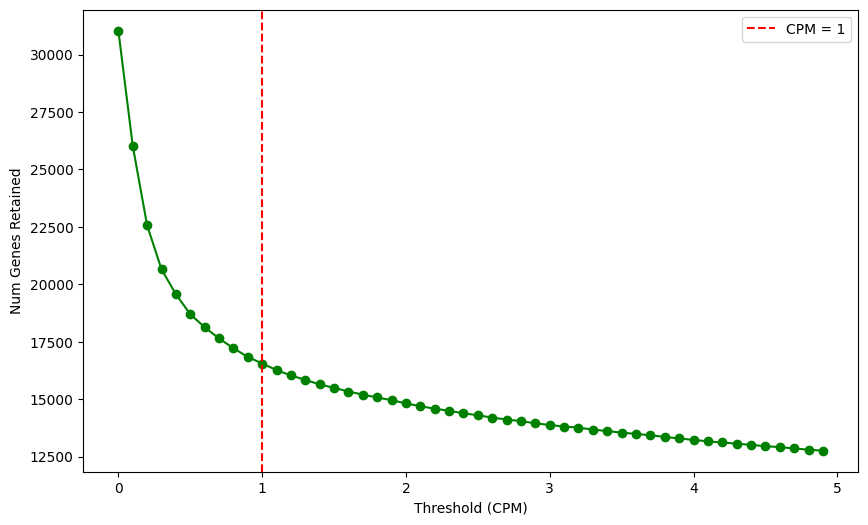

In [ ]:
# Drop the Gene Name column from countlist_5xFAD for counting
countlist_no_name = countlist_5xFAD.iloc[:, 1:]

# call plot_genes_retained_by_cpm function
plot_genes_retained_by_cpm(countlist_no_name)

In [ ]:
def filter_normalize(data, min_cpm=1.0, min_samples=2):
    # Separate the gene_name column
    gene_names = data.iloc[:, 0]  # First column is gene_name
    raw_counts = data.iloc[:, 1:]  # Remaining columns are raw counts

    # Convert raw counts to CPM
    cpm = raw_counts.apply(lambda x: (x / x.sum()) * 1e6, axis=0)

    # Filter genes based on CPM thresholds
    mask = (cpm > min_cpm).sum(axis=1) >= min_samples  # Keep genes with CPM > min_cpm in at least min_samples
    filtered_counts = raw_counts[mask]
    filtered_gene_names = gene_names[mask]

    # Compute geometric mean of non-zero values for each gene
    geometric_means = filtered_counts.apply(lambda row: np.exp(np.log(row[row > 0]).mean()), axis=1)

    # Calculate size factors by dividing each gene expression by its geometric mean
    size_factors = filtered_counts.div(geometric_means, axis=0).median(axis=0)

    # Normalize data by dividing each gene expression by the size factors
    normalized_counts = filtered_counts.div(size_factors, axis=1)

    # Add back the gene_name column
    normalized_data = pd.concat([filtered_gene_names, normalized_counts], axis=1)

    # Return normalized data as a DataFrame
    return normalized_data

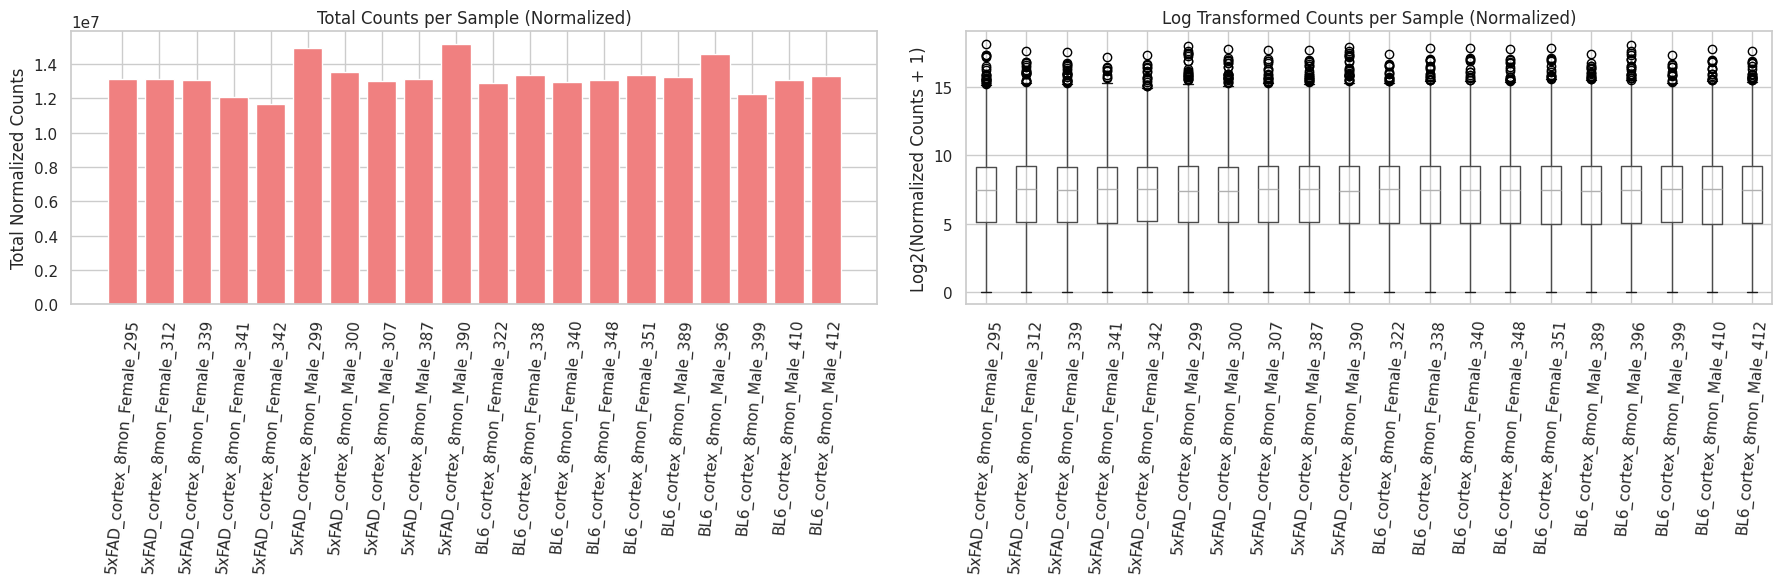

In [ ]:
# Apply the function to filter and normalize the data
filtered_normalized_5xFAD = filter_normalize(countlist_5xFAD, min_cpm=0.70)

# Plot the distribution of data after normalization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Total normalized counts per sample
total_counts_normalized = filtered_normalized_5xFAD.iloc[:, 1:].sum(axis=0)  # Exclude gene_name column
axes[0].bar(filtered_normalized_5xFAD.columns[1:], total_counts_normalized, color='lightcoral')
axes[0].set_ylabel('Total Normalized Counts')
axes[0].set_title('Total Counts per Sample (Normalized)')
axes[0].tick_params(axis='x', rotation=85)

# Log-transformed normalized counts per sample
log_normalized_data = filtered_normalized_5xFAD.iloc[:, 1:].apply(lambda x: np.log2(x + 1), axis=0)  # Exclude gene_name column
log_normalized_data.boxplot(ax=axes[1])
axes[1].set_ylabel('Log2(Normalized Counts + 1)')
axes[1].set_title('Log Transformed Counts per Sample (Normalized)')
axes[1].tick_params(axis='x', rotation=85)

plt.tight_layout()
plt.show()

In [ ]:
# download dataframe filtered and normalized data
filtered_normalized_5xFAD.to_csv('filtered_normalized_5xFAD.csv')
from google.colab import files
files.download('filtered_normalized_5xFAD.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Quality Control, Filterig, and Normalization for 3xTG-AD**

In [ ]:
# Load the CSV file from Google Drive
countlist_3xTG_AD = pd.read_csv('/content/drive/MyDrive/Mouse_AD/countlist_3xTG_AD.csv', index_col=0)

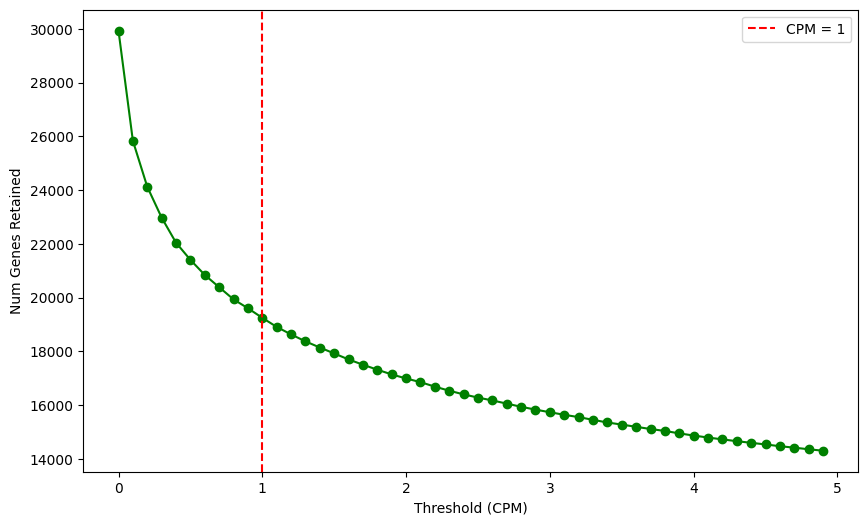

In [ ]:
# Drop the Gene Name column from countlist_3xTG_AD for counting
countlist_no_name = countlist_3xTG_AD.iloc[:, 1:]

# call plot_genes_retained_by_cpm function
plot_genes_retained_by_cpm(countlist_no_name)

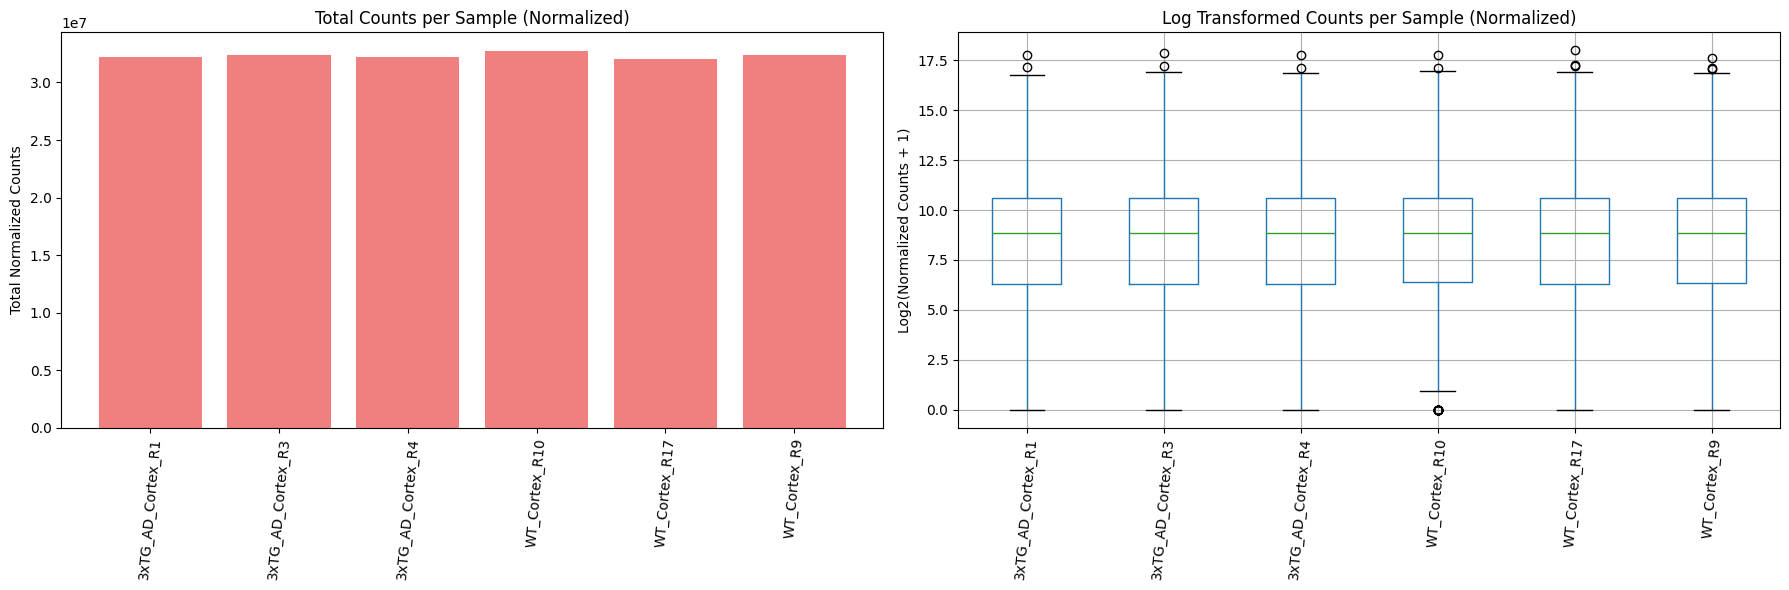

In [ ]:
# Apply the function to filter and normalize the data
filtered_normalized_3xTG_AD = filter_normalize(countlist_3xTG_AD, min_cpm=0.70, min_samples=1)

# Plot the distribution of data after normalization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Total normalized counts per sample
total_counts_normalized = filtered_normalized_3xTG_AD.iloc[:, 1:].sum(axis=0)  # Exclude gene_name column
axes[0].bar(filtered_normalized_3xTG_AD.columns[1:], total_counts_normalized, color='lightcoral')
axes[0].set_ylabel('Total Normalized Counts')
axes[0].set_title('Total Counts per Sample (Normalized)')
axes[0].tick_params(axis='x', rotation=85)

# Log-transformed normalized counts per sample
log_normalized_data = filtered_normalized_3xTG_AD.iloc[:, 1:].apply(lambda x: np.log2(x + 1), axis=0)  # Exclude gene_name column
log_normalized_data.boxplot(ax=axes[1])
axes[1].set_ylabel('Log2(Normalized Counts + 1)')
axes[1].set_title('Log Transformed Counts per Sample (Normalized)')
axes[1].tick_params(axis='x', rotation=85)

plt.tight_layout()
plt.show()

In [ ]:
# download dataframe filtered and normalized data
filtered_normalized_3xTG_AD.to_csv('filtered_normalized_3xTG_AD.csv')
from google.colab import files
files.download('filtered_normalized_3xTG_AD.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Analyses**

## **Differential Expression Analysis**

### **Differential Expression Analysis for 5xFAD Mice**


In [ ]:
# Separate the groups
treated_columns = ["5xFAD_cortex_8mon_Female_295", "5xFAD_cortex_8mon_Female_312", "5xFAD_cortex_8mon_Female_339", "5xFAD_cortex_8mon_Female_341", "5xFAD_cortex_8mon_Female_342", "5xFAD_cortex_8mon_Male_299", "5xFAD_cortex_8mon_Male_300", "5xFAD_cortex_8mon_Male_307", "5xFAD_cortex_8mon_Male_387", "5xFAD_cortex_8mon_Male_390"]

control_columns = ["BL6_cortex_8mon_Female_322", "BL6_cortex_8mon_Female_338", "BL6_cortex_8mon_Female_340", "BL6_cortex_8mon_Female_348", "BL6_cortex_8mon_Female_351", "BL6_cortex_8mon_Male_389", "BL6_cortex_8mon_Male_396", "BL6_cortex_8mon_Male_399", "BL6_cortex_8mon_Male_410", "BL6_cortex_8mon_Male_412"]

# Initialize a list to store results
results = []

# Perform differential expression analysis for each gene
for gene in filtered_normalized_5xFAD.index:
    # Extract treated and control group data for the current gene
    treated = pd.to_numeric(filtered_normalized_5xFAD.loc[gene, treated_columns], errors='coerce')
    control = pd.to_numeric(filtered_normalized_5xFAD.loc[gene, control_columns], errors='coerce')

    # Drop NaN values if present
    treated = treated.dropna()
    control = control.dropna()

    # Skip genes where either group is empty after coercion
    if treated.empty or control.empty:
        continue

    # Calculate mean expression levels for control and treated groups
    mean_control = np.mean(control)
    mean_treated = np.mean(treated)

    # Compute log2 fold change, adding 1 to avoid log(0)
    log2fc = np.log2((mean_treated + 1) / (mean_control + 1))

    # Perform t-test to compare control and treated groups
    t_stat, p_val = ttest_ind(treated, control)

    # Append results for the current gene to the results list
    results.append({"gene": gene,"Gene_Name": filtered_normalized_5xFAD.loc[gene, "Gene_Name"],"log2fc": log2fc,"t_stat": t_stat,"p_val": p_val})

# Convert results list to DataFrame for easier manipulation
results_df = pd.DataFrame(results)

# Convert p-values to numeric values, coercing errors to NaN if conversion fails
results_df['p_val'] = pd.to_numeric(results_df['p_val'], errors='coerce')
results_df = results_df.dropna(subset=['p_val'])

# Extract p-values as a numpy array for multiple testing correction
pvals = results_df['p_val'].values

# Apply multiple testing correction using Benjamini-Hochberg method
results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

# Calculate the absolute value of log2 fold change
results_df['abs_log2fc'] = results_df['log2fc'].abs()

# Filter results to get differentially expressed genes (DEGs) with p_adj < 0.05 and |log2fc| > 1
deg_5xFAD = results_df[(results_df['p_adj'] < 0.075) & (results_df['abs_log2fc'] > 0.75)]

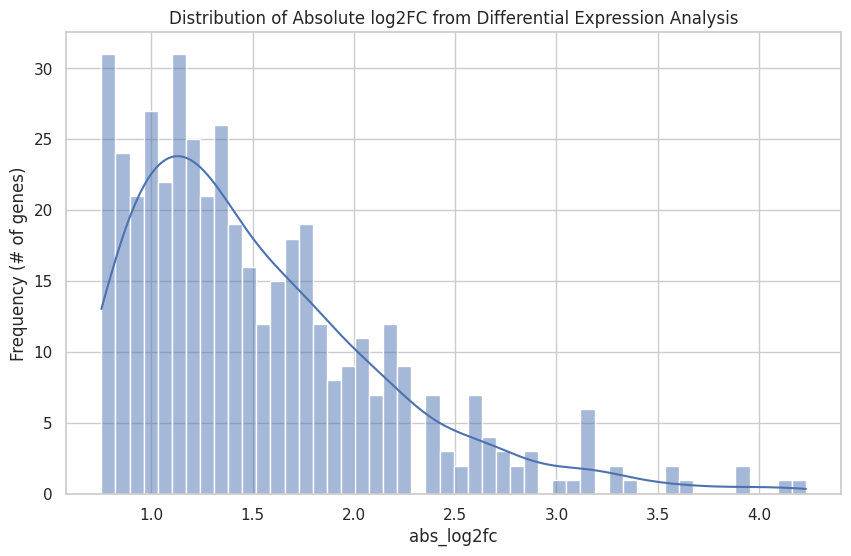

In [ ]:
# view distribution of scores
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(deg_5xFAD['abs_log2fc'], bins=50, kde=True)
plt.title('Distribution of Absolute log2FC from Differential Expression Analysis')
plt.xlabel('abs_log2fc')
plt.ylabel('Frequency (# of genes)')
plt.show()

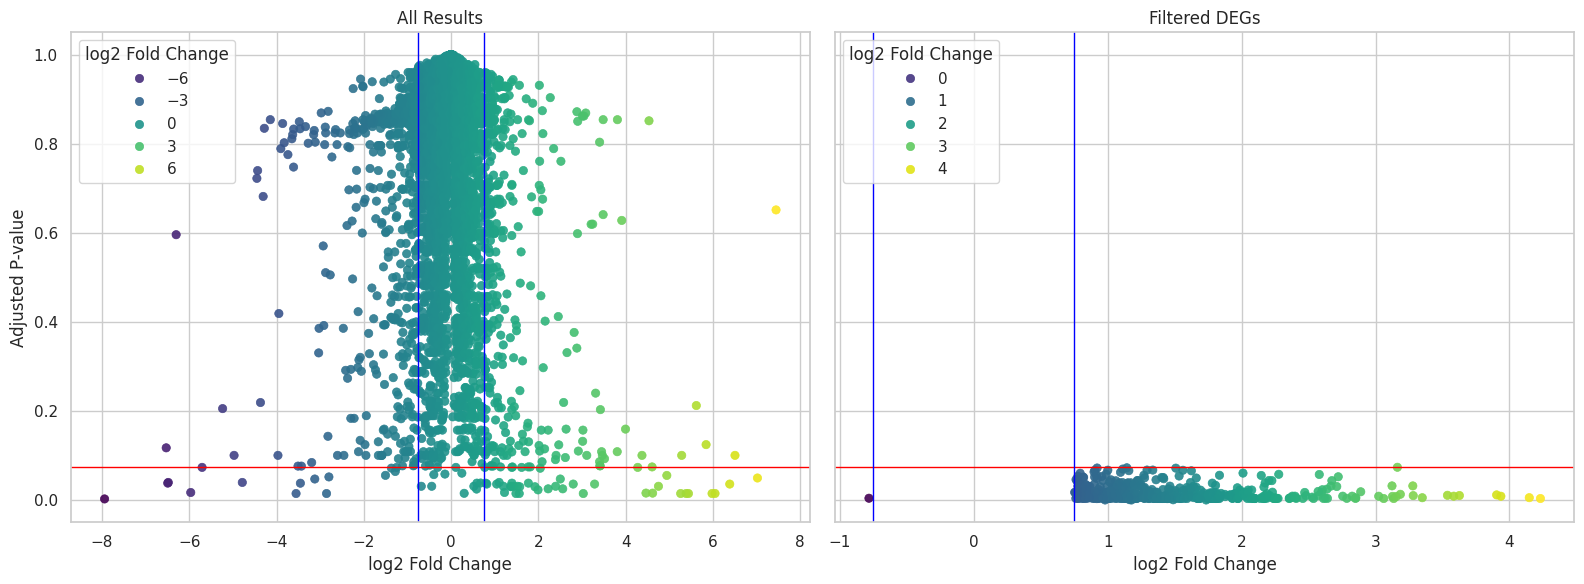

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Subplot 1: Scatterplot for the full results_df
sns.scatterplot(data=results_df, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None, ax=axes[0])
axes[0].axhline(y=0.075, color='red', linestyle='-', linewidth=1)
axes[0].axvline(x=0.75, color='blue', linestyle='-', linewidth=1)
axes[0].axvline(x=-0.75, color='blue', linestyle='-', linewidth=1)
axes[0].set_xlabel('log2 Fold Change')
axes[0].set_ylabel('Adjusted P-value')
axes[0].legend(title='log2 Fold Change', loc='upper left')
axes[0].set_title('All Results')

# Subplot 2: Scatterplot for the filtered DEGs (deg_5xFAD)
sns.scatterplot(data=deg_5xFAD, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None, ax=axes[1])
axes[1].axhline(y=0.075, color='red', linestyle='-', linewidth=1)
axes[1].axvline(x=0.75, color='blue', linestyle='-', linewidth=1)
axes[1].axvline(x=-0.75, color='blue', linestyle='-', linewidth=1)
axes[1].set_xlabel('log2 Fold Change')
axes[1].set_ylabel('Adjusted P-value')
axes[1].legend(title='log2 Fold Change', loc='upper left')
axes[1].set_title('Filtered DEGs')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# download dataframe filtered and normalized data
deg_5xFAD.to_csv('deg_5xFAD.csv')
from google.colab import files
files.download('deg_5xFAD.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Differential Expression Analysis for 3xTg-AD Mice**

In [ ]:
# Separate the groups
treated_columns = ['3xTG_AD_Cortex_R1','3xTG_AD_Cortex_R3','3xTG_AD_Cortex_R4']

control_columns = ['WT_Cortex_R10' ,'WT_Cortex_R17','WT_Cortex_R9' ]

# Initialize a list to store results
results = []

# Perform differential expression analysis for each gene
for gene in filtered_normalized_3xTG_AD.index:
    # Extract treated and control group data for the current gene
    treated = pd.to_numeric(filtered_normalized_3xTG_AD.loc[gene, treated_columns], errors='coerce')
    control = pd.to_numeric(filtered_normalized_3xTG_AD.loc[gene, control_columns], errors='coerce')

    # Drop NaN values if present
    treated = treated.dropna()
    control = control.dropna()

    # Skip genes where either group is empty after coercion
    if treated.empty or control.empty:
        continue

    # Calculate mean expression levels for control and treated groups
    mean_control = np.mean(control)
    mean_treated = np.mean(treated)

    # Compute log2 fold change, adding 1 to avoid log(0)
    log2fc = np.log2((mean_treated + 1) / (mean_control + 1))

    # Perform t-test to compare control and treated groups
    t_stat, p_val = ttest_ind(treated, control)

    # Append results for the current gene to the results list
    results.append({"gene": gene,"Gene_Name": filtered_normalized_3xTG_AD.loc[gene, "Gene_Name"],"log2fc": log2fc,"t_stat": t_stat,"p_val": p_val})

# Convert results list to DataFrame for easier manipulation
results_df = pd.DataFrame(results)

# Convert p-values to numeric values, coercing errors to NaN if conversion fails
results_df['p_val'] = pd.to_numeric(results_df['p_val'], errors='coerce')
results_df = results_df.dropna(subset=['p_val'])

# Extract p-values as a numpy array for multiple testing correction
pvals = results_df['p_val'].values

# Apply multiple testing correction using Benjamini-Hochberg method
results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

# Calculate the absolute value of log2 fold change
results_df['abs_log2fc'] = results_df['log2fc'].abs()

# Filter results to get differentially expressed genes (DEGs) with p_adj < 0.05 and |log2fc| > 1
deg_3xTG_AD = results_df[(results_df['p_adj'] < 0.075) & (results_df['abs_log2fc'] > 0.75)]

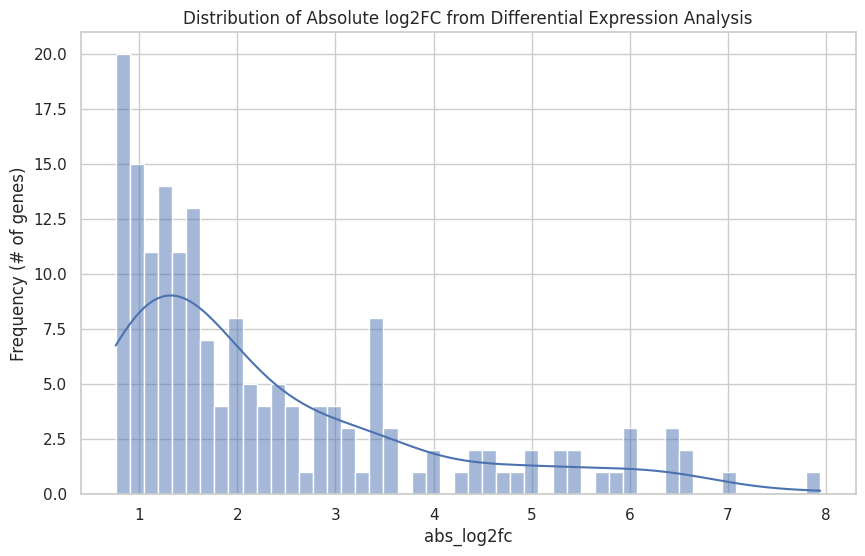

In [ ]:
# view distribution of scores
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(deg_3xTG_AD['abs_log2fc'], bins=50, kde=True)
plt.title('Distribution of Absolute log2FC from Differential Expression Analysis')
plt.xlabel('abs_log2fc')
plt.ylabel('Frequency (# of genes)')
plt.show()

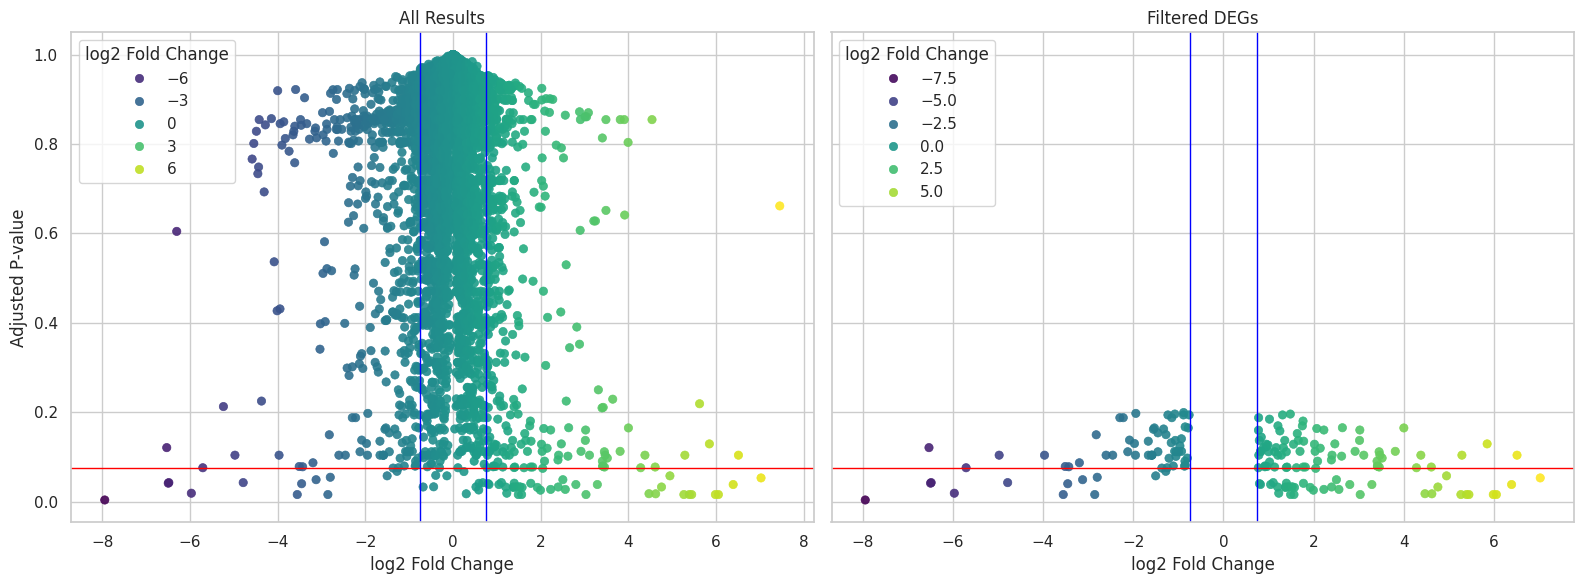

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Subplot 1: Scatterplot for the full results_df
sns.scatterplot(data=results_df, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None, ax=axes[0])
axes[0].axhline(y=0.075, color='red', linestyle='-', linewidth=1)
axes[0].axvline(x=0.75, color='blue', linestyle='-', linewidth=1)
axes[0].axvline(x=-0.75, color='blue', linestyle='-', linewidth=1)
axes[0].set_xlabel('log2 Fold Change')
axes[0].set_ylabel('Adjusted P-value')
axes[0].legend(title='log2 Fold Change', loc='upper left')
axes[0].set_title('All Results')

# Subplot 2: Scatterplot for the filtered DEGs
sns.scatterplot(data=deg_3xTG_AD, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None, ax=axes[1])
axes[1].axhline(y=0.075, color='red', linestyle='-', linewidth=1)
axes[1].axvline(x=0.75, color='blue', linestyle='-', linewidth=1)
axes[1].axvline(x=-0.75, color='blue', linestyle='-', linewidth=1)
axes[1].set_xlabel('log2 Fold Change')
axes[1].set_ylabel('Adjusted P-value')
axes[1].legend(title='log2 Fold Change', loc='upper left')
axes[1].set_title('Filtered DEGs')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# download dataframe filtered and normalized data
deg_3xTG_AD.to_csv('deg_3xTG_AD.csv')
from google.colab import files
files.download('deg_3xTG_AD.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Differential Expression Analysis for PS3O1S Mice**


In [ ]:
# Add a column for absolute log2 fold change
DEA_PS3O1S['abs_log2fc'] = DEA_PS3O1S['log2fc'].abs()

# Filter for DEGs based on log2fc and pval thresholds
deg_PS3O1S = DEA_PS3O1S[(DEA_PS3O1S['abs_log2fc'] > 0.75) & (DEA_PS3O1S['pval'] < 0.075)]

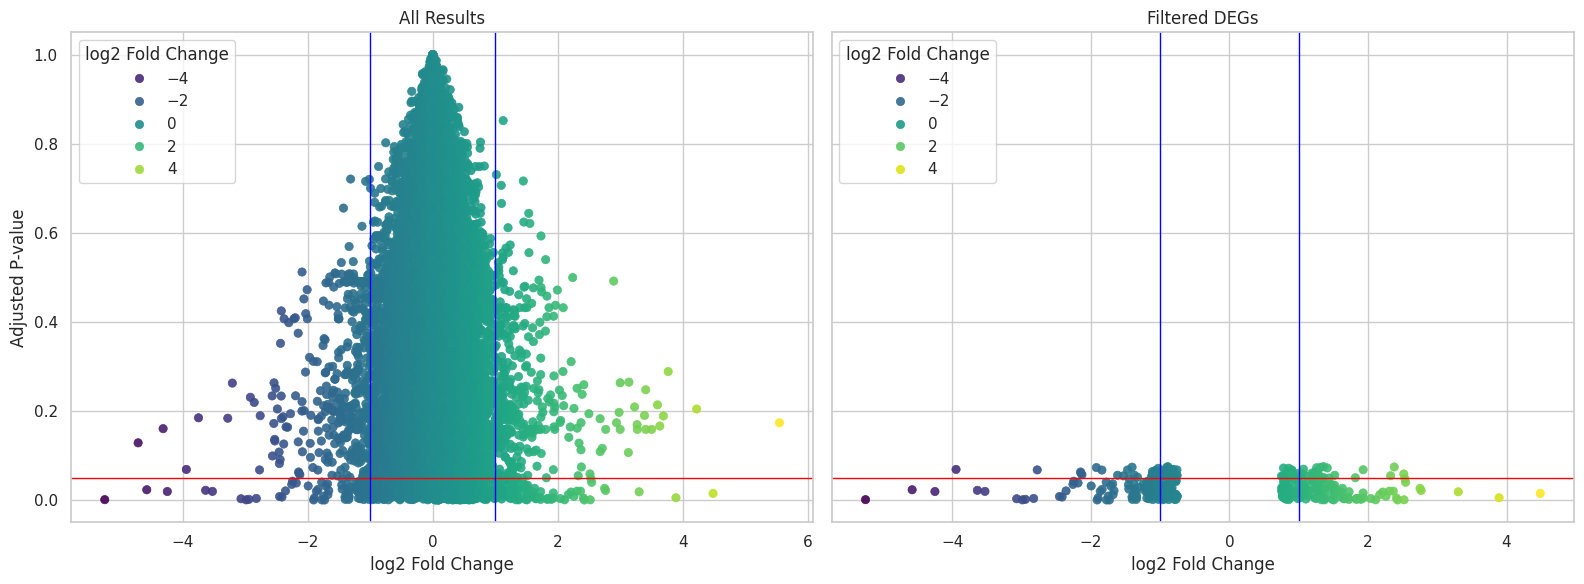

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Subplot 1: Scatterplot for the full results_df
sns.scatterplot(data=DEA_PS3O1S, x='log2fc', y='pval', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None, ax=axes[0])
axes[0].axhline(y=0.05, color='red', linestyle='-', linewidth=1)
axes[0].axvline(x=1, color='blue', linestyle='-', linewidth=1)
axes[0].axvline(x=-1, color='blue', linestyle='-', linewidth=1)
axes[0].set_xlabel('log2 Fold Change')
axes[0].set_ylabel('Adjusted P-value')
axes[0].legend(title='log2 Fold Change', loc='upper left')
axes[0].set_title('All Results')

# Subplot 2: Scatterplot for the filtered DEGs (deg_5xFAD)
sns.scatterplot(data=deg_PS3O1S, x='log2fc', y='pval', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None, ax=axes[1])
axes[1].axhline(y=0.05, color='red', linestyle='-', linewidth=1)
axes[1].axvline(x=1, color='blue', linestyle='-', linewidth=1)
axes[1].axvline(x=-1, color='blue', linestyle='-', linewidth=1)
axes[1].set_xlabel('log2 Fold Change')
axes[1].set_ylabel('Adjusted P-value')
axes[1].legend(title='log2 Fold Change', loc='upper left')
axes[1].set_title('Filtered DEGs')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# download dataframe filtered and normalized data
deg_PS3O1S.to_csv('deg_PS3O1S.csv')
from google.colab import files
files.download('deg_PS3O1S.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **All Group Comparison and Summary of Results**

In [ ]:
# Load the CSV file from Google Drive
deg_5xFAD = pd.read_csv('/content/drive/MyDrive/Mouse_AD/deg_5xFAD.csv', index_col=0)
deg_3xTG_AD = pd.read_csv('/content/drive/MyDrive/Mouse_AD/deg_3xTG_AD.csv', index_col=0)
deg_PS3O1S = pd.read_csv('/content/drive/MyDrive/Mouse_AD/deg_PS3O1S.csv', index_col=0)

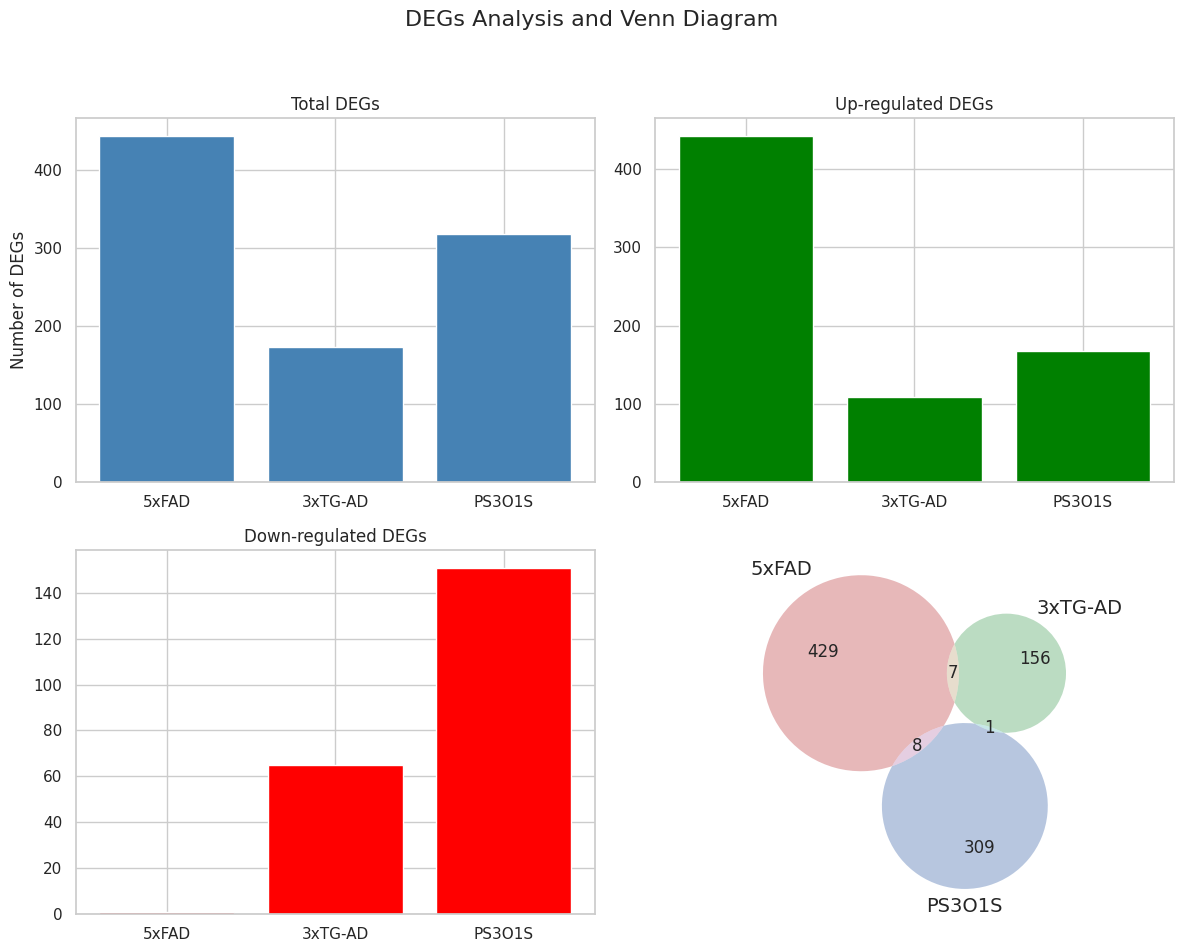

In [ ]:
# Define groups and datasets
groups = ['5xFAD', '3xTG-AD', 'PS3O1S']
datasets = [deg_5xFAD, deg_3xTG_AD, deg_PS3O1S]

# Initialize counts for total, up-regulated, and down-regulated DEGs
total_counts = []
up_counts = []
down_counts = []

# Calculate counts for each group
for dataset in datasets:
    total_counts.append(len(dataset))
    up_counts.append(len(dataset[dataset['log2fc'] > 0]))
    down_counts.append(len(dataset[dataset['log2fc'] < 0]))

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot total DEGs
axes[0, 0].bar(groups, total_counts, color='steelblue')
axes[0, 0].set_title('Total DEGs')
axes[0, 0].set_ylabel('Number of DEGs')

# Plot up-regulated DEGs
axes[0, 1].bar(groups, up_counts, color='green')
axes[0, 1].set_title('Up-regulated DEGs')

# Plot down-regulated DEGs
axes[1, 0].bar(groups, down_counts, color='red')
axes[1, 0].set_title('Down-regulated DEGs')

# Use gene_name column for comparison
genes_5xFAD = set(deg_5xFAD['Gene_Name'])  # Adjust column name as per your dataset
genes_3xTG_AD = set(deg_3xTG_AD['Gene_Name'])
genes_PS3O1S = set(deg_PS3O1S['gene_name'])

# Create the Venn diagram in the last subplot
axes[1, 1].axis('off')  # Turn off the axis for the Venn diagram subplot
venn = venn3(genes_5xFAD, genes_3xTG_AD, genes_PS3O1S],set_labels=('5xFAD', '3xTG-AD', 'PS3O1S'))

# Customize the diagram (optional)
for text in venn.set_labels:
    if text:  # Check if the label exists
        text.set_fontsize(14)
for text in venn.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(12)

# Add a title for the figure
fig.suptitle('DEGs Analysis and Venn Diagram of DEGs', fontsize=16)

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for suptitle
plt.show()

## **Functional Enrichment Analysis**



### **Gene Ontology (GO) Analysis**



#### **Biological Processes**

In [ ]:
# Define the gene lists for each model (DEGs) here
gene_list_5xFAD = deg_5xFAD['Gene_Name'].dropna().astype(str).tolist()
gene_list_3xTG_AD = deg_3xTG_AD['Gene_Name'].dropna().astype(str).tolist()
gene_list_PS3O1S = deg_PS3O1S['gene_name'].dropna().astype(str).tolist()

# Perform GO enrichment analysis for Biological Process (BP), Molecular Function (MF), and Cellular Component (CC)
enrichment_5xFAD_BP = gp.enrichr(gene_list_5xFAD, gene_sets=['GO_Biological_Process_2018'], organism='mouse')
enrichment_3xTG_AD_BP = gp.enrichr(gene_list_3xTG_AD, gene_sets=['GO_Biological_Process_2018'], organism='mouse')
enrichment_PS3O1S_BP = gp.enrichr(gene_list_PS3O1S, gene_sets=['GO_Biological_Process_2018'], organism='mouse')

# Extract the Biological Process results for each
enrichment_5xFAD_BP_df = enrichment_5xFAD_BP.results
enrichment_3xTG_AD_BP_df = enrichment_3xTG_AD_BP.results
enrichment_PS3O1S_BP_df = enrichment_PS3O1S_BP.results

In [ ]:
enrichment_5xFAD_BP_df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,neutrophil mediated immunity (GO:0002446),55/487,1.543671e-23,3.227817e-20,0,0,6.275505,329.622728,ARHGAP9;B4GALT1;HEXB;ITGB2;CTSZ;TCIRG1;CTSS;CX...
1,GO_Biological_Process_2018,neutrophil degranulation (GO:0043312),53/479,2.744658e-22,2.818666e-19,0,0,6.102943,302.994141,ARHGAP9;B4GALT1;HEXB;ITGB2;CTSZ;TCIRG1;CTSS;PY...
2,GO_Biological_Process_2018,neutrophil activation involved in immune respo...,53/483,4.043998e-22,2.818666e-19,0,0,6.044908,297.769961,ARHGAP9;B4GALT1;HEXB;ITGB2;CTSZ;TCIRG1;CTSS;PY...
3,GO_Biological_Process_2018,cytokine-mediated signaling pathway (GO:0019221),58/633,2.927374e-20,1.530285e-17,0,0,4.973263,223.685395,IFITM3;CD86;CNTF;CXCL9;CSF3R;CSF1;TNFRSF13B;IT...
4,GO_Biological_Process_2018,cellular response to cytokine stimulus (GO:007...,40/456,1.270725e-13,5.314172e-11,0,0,4.566950,135.611093,CD86;CEBPA;CNTF;CSF3R;SELPLG;CSF1;PTAFR;ITGB2;...


In [ ]:
enrichment_3xTG_AD_BP_df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,cell chemotaxis (GO:0060326),4/60,0.001454,0.386213,0,0,8.886343,58.058922,CXCL12;FPR3;CCR6;FPR2
1,GO_Biological_Process_2018,protein K6-linked ubiquitination (GO:0085020),2/8,0.001790,0.386213,0,0,41.057971,259.717618,PRKN;BRCA1
2,GO_Biological_Process_2018,complement receptor mediated signaling pathway...,2/10,0.002846,0.386213,0,0,30.790373,180.489777,FPR3;FPR2
3,GO_Biological_Process_2018,protein localization to kinetochore (GO:0034501),2/12,0.004129,0.386213,0,0,24.629814,135.207834,BUB1B;KNL1
4,GO_Biological_Process_2018,mRNA modification (GO:0016556),2/13,0.004854,0.386213,0,0,22.389610,119.289439,TRUB1;TRMT6


In [ ]:
enrichment_PS3O1S_BP_df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,L-alpha-amino acid transmembrane transport (GO...,4/15,0.000075,0.092510,0,0,22.780544,216.511647,SLC1A2;SLC1A6;SLC7A1;SLC25A22
1,GO_Biological_Process_2018,amino acid import across plasma membrane (GO:0...,3/7,0.000133,0.092510,0,0,46.852381,418.194611,SLC1A2;SLC1A6;SLC7A1
2,GO_Biological_Process_2018,acidic amino acid transport (GO:0015800),3/9,0.000312,0.144552,0,0,31.231746,252.165242,SLC1A2;SLC1A6;SLC25A22
3,GO_Biological_Process_2018,L-glutamate transport (GO:0015813),3/10,0.000440,0.153056,0,0,26.768707,206.899527,SLC1A2;SLC1A6;SLC25A22
4,GO_Biological_Process_2018,glycosphingolipid metabolic process (GO:0006687),5/54,0.001646,0.344323,0,0,6.400535,41.023304,B3GALNT1;GM2A;CPTP;ARSG;ST6GALNAC5


#### **Molecular Function**

In [ ]:
# Repeat the same for Molecular Function (MF)
enrichment_5xFAD_MF = gp.enrichr(gene_list_5xFAD, gene_sets=['GO_Molecular_Function_2018'], organism='mouse')
enrichment_3xTG_AD_MF = gp.enrichr(gene_list_3xTG_AD, gene_sets=['GO_Molecular_Function_2018'], organism='mouse')
enrichment_PS3O1S_MF = gp.enrichr(gene_list_PS3O1S, gene_sets=['GO_Molecular_Function_2018'], organism='mouse')

# Extract the Molecular Function results for each
enrichment_5xFAD_MF_df = enrichment_5xFAD_MF.results
enrichment_3xTG_AD_MF_df = enrichment_3xTG_AD_MF.results
enrichment_PS3O1S_MF_df = enrichment_PS3O1S_MF.results

In [ ]:
enrichment_5xFAD_MF_df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Molecular_Function_2018,Toll-like receptor binding (GO:0035325),4/9,0.000027,0.00481,0,0,35.630068,374.300799,TLR1;UNC93B1;TLR6;TLR2
1,GO_Molecular_Function_2018,phosphotyrosine residue binding (GO:0001784),6/29,0.000035,0.00481,0,0,11.660929,119.581788,FGR;HCK;SH3BP2;PLCG2;SAMSN1;VAV1
2,GO_Molecular_Function_2018,chemokine activity (GO:0008009),7/46,0.000063,0.00481,0,0,8.034933,77.679893,CXCL10;CXCL9;CCL5;CCL4;CCL3;CXCL5;CXCL16
3,GO_Molecular_Function_2018,cysteine-type endopeptidase activity (GO:0004197),9/81,0.000075,0.00481,0,0,5.612039,53.280182,PYCARD;CTSL;CTSZ;CASP4;CAPN3;CTSH;CTSD;CTSS;CTSC
4,GO_Molecular_Function_2018,protein phosphorylated amino acid binding (GO:...,6/34,0.000091,0.00481,0,0,9.576169,89.133555,FGR;HCK;SH3BP2;PLCG2;SAMSN1;VAV1


In [ ]:
enrichment_3xTG_AD_MF_df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Molecular_Function_2018,G-protein coupled peptide receptor activity (G...,4/64,0.001847,0.169525,0,0,8.292243,52.191592,GLP1R;CYSLTR2;FPR3;FPR2
1,GO_Molecular_Function_2018,phosphatidylcholine 1-acylhydrolase activity (...,2/10,0.002846,0.169525,0,0,30.790373,180.489777,PLA2G4B;LIPG
2,GO_Molecular_Function_2018,complement receptor activity (GO:0004875),2/11,0.003460,0.169525,0,0,27.367840,155.081843,FPR3;FPR2
3,GO_Molecular_Function_2018,lysophospholipase activity (GO:0004622),2/19,0.010307,0.378778,0,0,14.483011,66.258957,PLA2G4B;PLBD1
4,GO_Molecular_Function_2018,phospholipase activity (GO:0004620),3/69,0.018809,0.465820,0,0,5.616761,22.317701,PLA2G4B;LIPG;PLBD1


In [ ]:
enrichment_PS3O1S_MF_df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Molecular_Function_2018,high-affinity glutamate transmembrane transpor...,3/7,0.000133,0.043198,0,0,46.852381,418.194611,SLC1A2;SLC1A6;SLC25A22
1,GO_Molecular_Function_2018,acidic amino acid transmembrane transporter ac...,3/13,0.001012,0.137862,0,0,18.735238,129.199795,SLC1A2;SLC1A6;SLC25A22
2,GO_Molecular_Function_2018,L-glutamate transmembrane transporter activity...,3/14,0.001273,0.137862,0,0,17.031169,113.541939,SLC1A2;SLC1A6;SLC25A22
3,GO_Molecular_Function_2018,PDZ domain binding (GO:0030165),5/62,0.003038,0.241413,0,0,5.499972,31.880116,KCNJ4;ADAM17;FZD2;PLEKHA2;GNG12
4,GO_Molecular_Function_2018,ubiquitin protein ligase activity (GO:0061630),9/192,0.003714,0.241413,0,0,3.103454,17.365789,RNF144B;ITCH;SMURF2;FANCL;TRIM13;TRIM37;BTRC;M...


#### **Cellular Component**

In [ ]:
# Repeat the same for Cellular Component (CC)
enrichment_5xFAD_CC = gp.enrichr(gene_list_5xFAD, gene_sets=['GO_Cellular_Component_2018'], organism='mouse')
enrichment_3xTG_AD_CC = gp.enrichr(gene_list_3xTG_AD, gene_sets=['GO_Cellular_Component_2018'], organism='mouse')
enrichment_PS3O1S_CC = gp.enrichr(gene_list_PS3O1S, gene_sets=['GO_Cellular_Component_2018'], organism='mouse')

# Extract the Cellular Component results for each
enrichment_5xFAD_CC_df = enrichment_5xFAD_CC.results
enrichment_3xTG_AD_CC_df = enrichment_3xTG_AD_CC.results
enrichment_PS3O1S_CC_df = enrichment_PS3O1S_CC.results

In [ ]:
enrichment_5xFAD_CC_df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Cellular_Component_2018,phagocytic vesicle (GO:0045335),18/83,2.327583e-13,4.189650e-11,0,0,12.700670,369.446931,NCF1;ITGB5;NCF2;ANXA3;UNC93B1;SLC11A1;NCF4;TAP...
1,GO_Cellular_Component_2018,tertiary granule (GO:0070820),23/164,1.885410e-12,1.696869e-10,0,0,7.540831,203.578874,GSDMD;CD53;FCER1G;CD300A;SLC11A1;ITGB2;PTAFR;C...
2,GO_Cellular_Component_2018,specific granule (GO:0042581),20/160,4.390350e-10,2.634210e-08,0,0,6.557582,141.292558,GSDMD;CD53;ANXA3;HVCN1;CTSZ;ITGB2;PLAUR;CYBB;C...
3,GO_Cellular_Component_2018,tertiary granule membrane (GO:0070821),14/73,6.266986e-10,2.820144e-08,0,0,10.784718,228.534167,CD53;FCER1G;CD300A;SLC11A1;ITGB2;PTAFR;CYBB;CY...
4,GO_Cellular_Component_2018,lytic vacuole (GO:0000323),19/183,2.677211e-08,9.637961e-07,0,0,5.298939,92.391791,GRN;UNC93B1;SLC11A1;CTSZ;LAPTM5;IFI30;CTSS;GFA...


In [ ]:
enrichment_3xTG_AD_CC_df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Cellular_Component_2018,condensed chromosome kinetochore (GO:0000777),3/19,0.000468,0.035089,0,0,23.227734,178.095526,HJURP;BUB1B;KNL1
1,GO_Cellular_Component_2018,"condensed chromosome, centromeric region (GO:0...",3/26,0.001204,0.045146,0,0,16.152717,108.581703,HJURP;BUB1B;KNL1
2,GO_Cellular_Component_2018,nuclear ubiquitin ligase complex (GO:0000152),3/41,0.004514,0.091018,0,0,9.769243,52.758553,CBX7;BUB1B;BRCA1
3,GO_Cellular_Component_2018,germ plasm (GO:0060293),2/13,0.004854,0.091018,0,0,22.389610,119.289439,EXD1;DDX4
4,GO_Cellular_Component_2018,P granule (GO:0043186),2/16,0.007349,0.110242,0,0,17.589175,86.417868,EXD1;DDX4


In [ ]:
enrichment_PS3O1S_CC_df.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Cellular_Component_2018,intrinsic component of mitochondrial inner mem...,4/29,0.001088,0.146265,0,0,10.016306,68.342942,COA3;MCUR1;COQ2;L2HGDH
1,GO_Cellular_Component_2018,integral component of mitochondrial inner memb...,4/33,0.001784,0.146265,0,0,8.632989,54.638653,COA3;MCUR1;COQ2;L2HGDH
2,GO_Cellular_Component_2018,U6 snRNP (GO:0005688),2/8,0.006624,0.362091,0,0,20.755274,104.131592,LSM7;LSM5
3,GO_Cellular_Component_2018,integral component of mitochondrial membrane (...,4/56,0.012044,0.493803,0,0,4.808917,21.251518,COA3;MCUR1;COQ2;L2HGDH
4,GO_Cellular_Component_2018,integral component of endoplasmic reticulum me...,6/128,0.016624,0.545273,0,0,3.083228,12.631668,HSPA5;TMEM33;DERL1;TEX261;MARCH6;TAPBP


Next, we'll look at the overlap between biological process, molecular functions, and cellular components for each of our mouse models.

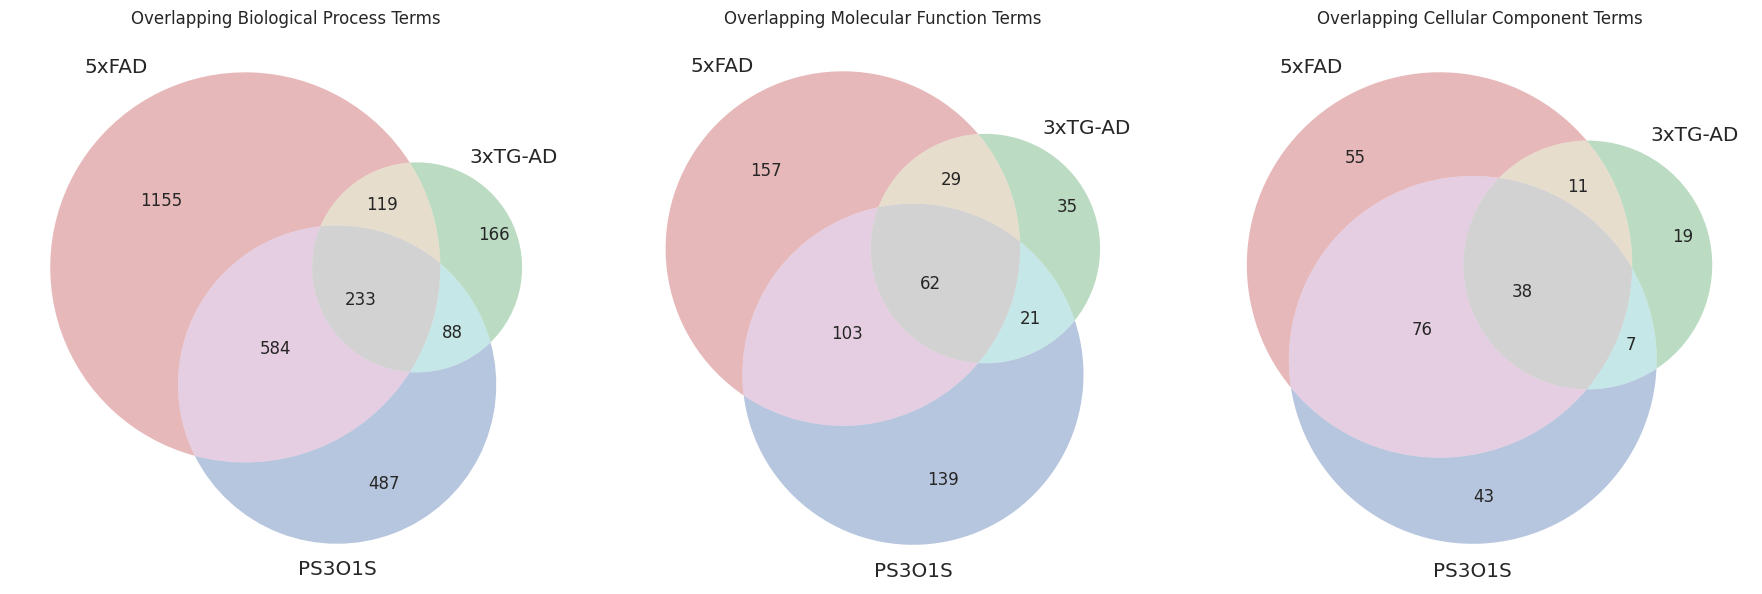

In [ ]:
# Find overlapping Biological Process terms across the three datasets
bp_5xFAD_terms = set(enrichment_5xFAD_BP_df['Term'])
bp_3xTG_AD_terms = set(enrichment_3xTG_AD_BP_df['Term'])
bp_PS3O1S_terms = set(enrichment_PS3O1S_BP_df['Term'])

# Find overlapping Molecular Function terms across the three datasets
mf_5xFAD_terms = set(enrichment_5xFAD_MF_df['Term'])
mf_3xTG_AD_terms = set(enrichment_3xTG_AD_MF_df['Term'])
mf_PS3O1S_terms = set(enrichment_PS3O1S_MF_df['Term'])

# Find overlapping Cellular Component terms across the three datasets
cc_5xFAD_terms = set(enrichment_5xFAD_CC_df['Term'])
cc_3xTG_AD_terms = set(enrichment_3xTG_AD_CC_df['Term'])
cc_PS3O1S_terms = set(enrichment_PS3O1S_CC_df['Term'])

# Create subplots with 1 row and 3 columns
plt.figure(figsize=(18, 6))

# Biological Process Venn Diagram
plt.subplot(1, 3, 1)  # (number of rows, number of columns, plot index)
venn3([bp_5xFAD_terms, bp_3xTG_AD_terms, bp_PS3O1S_terms], set_labels=('5xFAD', '3xTG-AD', 'PS3O1S'))
plt.title('Overlapping Biological Process Terms')

# Molecular Function Venn Diagram
plt.subplot(1, 3, 2)  # (number of rows, number of columns, plot index)
venn3([mf_5xFAD_terms, mf_3xTG_AD_terms, mf_PS3O1S_terms], set_labels=('5xFAD', '3xTG-AD', 'PS3O1S'))
plt.title('Overlapping Molecular Function Terms')

# Cellular Component Venn Diagram
plt.subplot(1, 3, 3)  # (number of rows, number of columns, plot index)
venn3([cc_5xFAD_terms, cc_3xTG_AD_terms, cc_PS3O1S_terms], set_labels=('5xFAD', '3xTG-AD', 'PS3O1S'))
plt.title('Overlapping Cellular Component Terms')

# Show all the plots
plt.tight_layout()
plt.show()

## Pathway Analysis

In [ ]:
# Perform functional enrichment analysis for each dataset
enrichment_5xFAD = gp.enrichr(gene_list_5xFAD, gene_sets=['KEGG_2016'], organism='mouse')
enrichment_3xTG_AD = gp.enrichr(gene_list_3xTG_AD, gene_sets=['KEGG_2016'], organism='mouse')
enrichment_PS3O1S = gp.enrichr(gene_list_PS3O1S, gene_sets=['KEGG_2016'], organism='mouse')

# Retrieve and display results for each analysis
enrichment_df_5xFAD = enrichment_5xFAD.results
enrichment_df_3xTG_AD = enrichment_3xTG_AD.results
enrichment_df_PS3O1S = enrichment_PS3O1S.results

NameError: name 'gene_list_5xFAD' is not defined

In [ ]:
enrichment_df_5xFAD.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Osteoclast differentiation Homo sapiens hsa04380,21/132,1.445706e-12,3.007069e-10,0,0,8.717945,237.672318,SPI1;NCF1;CSF1;NCF2;STAT1;NCF4;CYBB;CYBA;TREM2...
1,KEGG_2016,Toll-like receptor signaling pathway Homo sapi...,18/106,1.883931e-11,1.959288e-09,0,0,9.370107,231.395498,CD86;CXCL9;TICAM2;STAT1;IRAK4;PIK3CG;TLR1;CXCL...
2,KEGG_2016,Lysosome Homo sapiens hsa04142,18/123,2.423848e-10,1.680534e-08,0,0,7.846185,173.718415,CD63;SLC11A1;HEXB;CTSZ;HEXA;LAPTM5;TCIRG1;CTSS...
3,KEGG_2016,Tuberculosis Homo sapiens hsa05152,21/178,4.748209e-10,2.469068e-08,0,0,6.149063,132.008592,CD74;FCER1G;STAT1;IL10RA;ITGB2;CARD9;LSP1;TCIR...
4,KEGG_2016,Phagosome Homo sapiens hsa04145,19/154,1.504592e-09,6.259101e-08,0,0,6.446855,130.966218,NCF1;ITGB5;NCF2;NCF4;ITGB2;TAP1;CYBB;CYBA;TCIR...


In [ ]:
enrichment_df_3xTG_AD.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Maturity onset diabetes of the young Homo sapi...,2/26,0.018874,0.79406,0,0,10.255176,40.712679,HNF1B;HNF1A
1,KEGG_2016,beta-Alanine metabolism Homo sapiens hsa00410,2/31,0.026300,0.79406,0,0,8.484900,30.869804,UPB1;ALDH7A1
2,KEGG_2016,Pyruvate metabolism Homo sapiens hsa00620,2/40,0.042073,0.79406,0,0,6.472377,20.506685,GLO1;ALDH7A1
3,KEGG_2016,"Valine, leucine and isoleucine degradation Hom...",2/48,0.058349,0.79406,0,0,5.344585,15.185640,IVD;ALDH7A1
4,KEGG_2016,Lysine degradation Homo sapiens hsa00310,2/52,0.067176,0.79406,0,0,4.916025,13.275459,SUV39H2;ALDH7A1


In [ ]:
enrichment_df_PS3O1S.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Ubiquinone and other terpenoid-quinone biosynt...,3/11,0.000598,0.101599,0,0,23.421429,173.846051,VKORC1L1;COQ3;COQ2
1,KEGG_2016,Protein processing in endoplasmic reticulum Ho...,7/169,0.018687,0.790248,0,0,2.712080,10.793869,NSFL1C;HSPA5;HSPA4L;DERL1;MARCH6;SVIP;HSPA1A
2,KEGG_2016,Glycosphingolipid biosynthesis - globo series ...,2/14,0.020216,0.790248,0,0,10.374473,40.473807,B3GALNT1;B3GALT5
3,KEGG_2016,Ubiquitin mediated proteolysis Homo sapiens hs...,6/137,0.022416,0.790248,0,0,2.870082,10.900495,ITCH;SMURF2;FANCL;TRIM37;BTRC;TRIM32
4,KEGG_2016,Endocytosis Homo sapiens hsa04144,9/259,0.023243,0.790248,0,0,2.263922,8.516352,EHD2;ITCH;SMAD3;PARD6A;GRK5;SMURF2;PSD2;AGAP1;...


Next, we'll find overlapping pathways

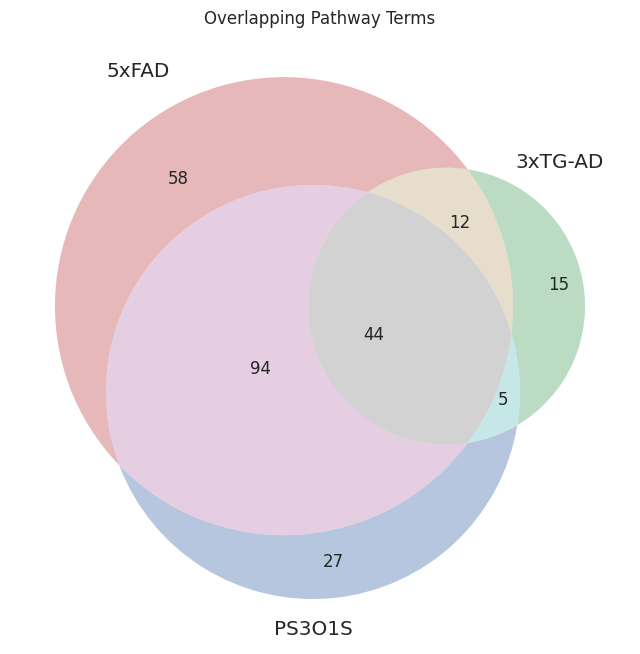

In [ ]:
# Find overlapping Biological Process terms across the three datasets
bp_5xFAD_terms = set(enrichment_df_5xFAD['Term'])
bp_3xTG_AD_terms = set(enrichment_df_3xTG_AD['Term'])
bp_PS3O1S_terms = set(enrichment_df_PS3O1S['Term'])

# Venn Diagram for Biological Process
plt.figure(figsize=(8, 8))
venn3([bp_5xFAD_terms, bp_3xTG_AD_terms, bp_PS3O1S_terms], set_labels=('5xFAD', '3xTG-AD', 'PS3O1S'))
plt.title('Overlapping Pathway Terms')
plt.show()

## **PPI Network Analysis**

<ipython-input-18-c6987fab467f>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  protein1 = row[0]  # ENSEMBL ID of the first protein
<ipython-input-18-c6987fab467f>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  protein2 = row[1]  # ENSEMBL ID of the second protein
<ipython-input-18-c6987fab467f>:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  protein_name = row[2]  # This could be a gene/protein name (not used here, but you 

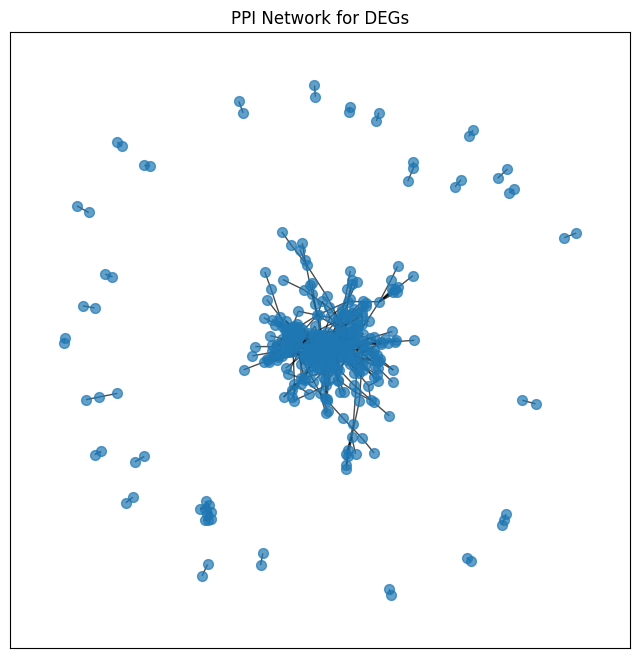

In [ ]:
# Function to fetch PPI data for a list of genes from STRING database
def fetch_string_ppi(gene_list, species='9606'):
    base_url = "https://string-db.org/api/tsv/network"
    genes = "\n".join(gene_list)
    params = {'identifiers': genes,'species': species, 'limit': 1 }
    response = requests.post(base_url, data=params)
    if response.status_code == 200:
        return response.text
    else:
        return None

# Fetch PPI network for your gene lists
gene_list_all = gene_list_5xFAD + gene_list_3xTG_AD + gene_list_PS3O1S
ppi_data = fetch_string_ppi(gene_list_all, species='10090')

# Parse the PPI data into a pandas DataFrame
ppi_df = pd.read_csv(StringIO(ppi_data), sep="\t")

# Filter interactions with a score above 0.7
ppi_df_filtered = ppi_df[ppi_df['score'] > 0.7]

# Create an empty graph
G = nx.Graph()

# Add edges to the graph from the filtered PPI data
for index, row in ppi_df_filtered.iterrows():
    protein1 = row[0]  # ENSEMBL ID of the first protein
    protein2 = row[1]  # ENSEMBL ID of the second protein
    protein_name = row[2]  # This could be a gene/protein name (not used here, but you could use it for node labels)
    G.add_edge(protein1, protein2, weight=row['score'])

# Visualize the network
plt.figure(figsize=(8, 8))
nx.draw_networkx(G, node_size=50, with_labels=False, font_size=10, width=1, alpha=0.7)
plt.title('PPI Network for DEGs')
plt.show()

In [ ]:
# Calculate degree centrality for each node
degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality (most important hubs)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 most important proteins
print("Top 10 most important proteins based on degree centrality:")
for protein, centrality in sorted_degree_centrality[:10]:
    print(f"{protein}: {centrality}")

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Sort nodes by betweenness centrality
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 proteins by betweenness centrality
print("\nTop 10 proteins based on betweenness centrality:")
for protein, centrality in sorted_betweenness[:10]:
    print(f"{protein}: {centrality}")

Top 10 most important proteins based on degree centrality:
10090.ENSMUSP00000025263: 0.16541353383458646
10090.ENSMUSP00000138350: 0.12030075187969924
10090.ENSMUSP00000141132: 0.10776942355889724
10090.ENSMUSP00000047646: 0.09774436090225563
10090.ENSMUSP00000087047: 0.09022556390977443
10090.ENSMUSP00000026571: 0.08771929824561403
10090.ENSMUSP00000131938: 0.08020050125313283
10090.ENSMUSP00000039600: 0.07769423558897243
10090.ENSMUSP00000032800: 0.07769423558897243
10090.ENSMUSP00000099889: 0.07518796992481203

Top 10 proteins based on betweenness centrality:
10090.ENSMUSP00000025263: 0.17862791784211218
10090.ENSMUSP00000141132: 0.0952089258753974
10090.ENSMUSP00000138350: 0.07148731617991505
10090.ENSMUSP00000095171: 0.06113369365492483
10090.ENSMUSP00000032800: 0.056767523342372644
10090.ENSMUSP00000099404: 0.05188411451297515
10090.ENSMUSP00000017290: 0.048901234596888644
10090.ENSMUSP00000005889: 0.044901945271063635
10090.ENSMUSP00000028222: 0.041235469883139704
10090.ENSMUSP0